# Overview - Challenge

© Johannes Lumma

In the following we will attempt to predict Target_Flag. This is a classification problem. <br> We will start by understanding the data, cleaning and preprocessing it and finally test two different models (a Logistic Regression and a SVC).

# Importing Libraries & Loading Data

## Importing Relevant Libraries

In [2]:
# Data Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')
from scipy import stats

# Data Cleaning and Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import make_scorer


## Loading Data

In [593]:
# Loading Data from github repository
train_data = pd.read_csv('https://github.com/descartes-underwriting/data-scientist-technical-test/blob/main/data/auto-insurance-fall-2017/train_auto.csv?raw=true')
test_data = pd.read_csv('https://github.com/descartes-underwriting/data-scientist-technical-test/blob/main/data/auto-insurance-fall-2017/test_auto.csv?raw=true')

In [594]:
train_data.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [596]:
# Target is not equally distributed
train_data['TARGET_FLAG'].value_counts()

0    6008
1    2153
Name: TARGET_FLAG, dtype: int64

# Data Cleaning - Initial Feature Overview

In this section we will clean the data and preprocess it.

## Data Cleaning and Feature Encoding

Let us start by converting columns with prices and income into floats by removing the dollar signs and replacing commas by dots.

In [570]:
str_cols = ['INCOME','BLUEBOOK','HOME_VAL','OLDCLAIM']    

train_data[str_cols] = train_data[str_cols].replace('\$', '', regex=True)
train_data[str_cols] = train_data[str_cols].replace(',', '.', regex=True)

test_data[str_cols] = test_data[str_cols].replace('\$', '', regex=True)
test_data[str_cols] = test_data[str_cols].replace(',', '.', regex=True)

train_data[str_cols] = train_data[str_cols].astype(float, errors = 'raise')
test_data[str_cols] = test_data[str_cols].astype(float, errors = 'raise')

Split data into input and target

In [571]:
X = train_data.drop(columns=['TARGET_FLAG','TARGET_AMT','INDEX'])
X_test = test_data.drop(columns=['TARGET_FLAG','TARGET_AMT','INDEX'])

y = train_data.TARGET_FLAG
y_test = test_data.TARGET_FLAG

X.shape

(8161, 23)

## Understanding Data


Before starting with the preprocessing let us understand our data a little bit better:

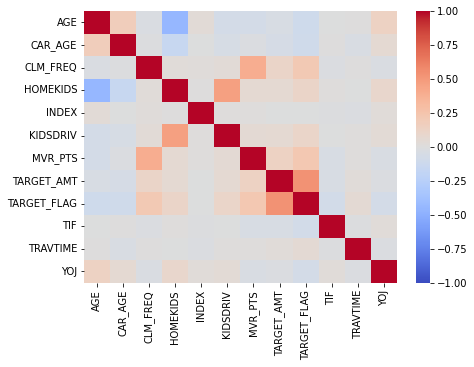

In [555]:
feat_numerical_complete = sorted(train_data.select_dtypes(include=["int64", "float64"]).columns)
corr_num = train_data[feat_numerical_complete].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr_num, cmap='coolwarm',vmin=-1, vmax=1);

One notices for instance that more than a third of entries in the column HOME_VAL is zero. We will check whether this might be a sign of an error or if is reasonable:

In [383]:
X['HOME_VAL'].value_counts()

0.000      2294
238.724       3
196.320       3
332.673       3
123.109       3
           ... 
190.282       1
274.122       1
249.869       1
128.607       1
197.017       1
Name: HOME_VAL, Length: 5106, dtype: int64

As can be seen below with the eye that HOME_VAL correlates with martital status

In [335]:
X['HOME_VAL'][X['MSTATUS'] == 'z_No'].value_counts()

0.000      1951
153.061       3
316.035       2
143.884       2
241.544       2
           ... 
58.318        1
211.621       1
271.024       1
279.674       1
232.182       1
Name: HOME_VAL, Length: 1088, dtype: int64

Of the total 2294 people that have a home value of 0, 1951 (85%) are not married. The reason could be that non-married people tend to live for rent.
We will therefore not impute those entries later on but leave them as they are.

## Imputing and Encoding the data

Let us start by analyzing the categorical features and one-hot-encode them. <br>
We will store the number of unique values for each categorical feature in our training set in the series feat_categorical_nunique.

In [326]:
feat_categorical_nunique = X.select_dtypes(include='object').nunique()

In [327]:
X.select_dtypes(include=['object']).nunique()

PARENT1       2
MSTATUS       2
SEX           2
EDUCATION     5
JOB           8
CAR_USE       2
CAR_TYPE      6
RED_CAR       2
REVOKED       2
URBANICITY    2
dtype: int64

In [329]:
X.select_dtypes(include=['object']).nunique().sum()

33

We see that we have 33 unique categorical features that need to be encoded. 
Dropping one column for all binary features (using drop = 'if_binary'), however, results in 26 additional columns.

Let us now preprocess the data, i.e.

For categorical features

    Simple-Impute with most frequent values
    One-Hot-Encode features 
    Drop all others features
    
    
and for numerical features

    Simple-Impute with strategy 'mean'
    Min-Max Scale



In [19]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler())

preproc_categorical_baseline = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
    OneHotEncoder(sparse=False,handle_unknown="ignore",drop='if_binary'))

preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_categorical_baseline, make_column_selector(dtype_include=["object"])),
    remainder="drop")

preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6a024c10d0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6a024c1d30>)])

Let us check the shape of our preprocessed data set:

In [20]:
shape_preproc_baseline = preproc_baseline.fit_transform(X).shape
shape_preproc_baseline

(8161, 39)

Shape as expected. 39 because of 13 numerical features and 26 categorical ones after enconding. $\newline$

Below we see the preprocessed data set after imputing, encoding and rescaling the data:


In [21]:
pd.DataFrame(preproc_baseline.fit_transform(X))

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.00,0.676923,0.0,0.478261,0.067552,0.000000,0.065693,0.186547,0.416667,0.004465,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.00,0.415385,0.0,0.478261,0.091724,0.290588,0.124088,0.196952,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.00,0.292308,0.2,0.434783,0.016087,0.140284,0.000000,0.036782,0.125000,0.038729,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.00,0.538462,0.0,0.608696,0.064953,0.345936,0.197080,0.204279,0.250000,0.000000,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.00,0.523077,0.0,0.456491,0.115332,0.275534,0.226277,0.241794,0.000000,0.019236,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8156,0.00,0.292308,0.0,0.478261,0.043242,0.000000,0.335766,0.378517,0.375000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8157,0.25,0.446154,0.4,0.391304,0.165164,0.436328,0.116788,0.172479,0.583333,0.000000,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8158,0.00,0.461538,0.0,0.391304,0.107527,0.375689,0.226277,0.336899,0.208333,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8159,0.00,0.523077,0.0,0.304348,0.043576,0.168588,0.226277,0.308470,0.208333,0.000000,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Testing

Let us now use two models to make predictions.
We will start with a logistic regression and then proceed with
a support vector classifier. For both we will run a grid search for different hyperparameters.

## Baseline Score

To get a very naive benchmark, we can determine a baseline accuracy score by considering the number of "successful claims" divided by the number of total claims:

In [216]:
baseline_score = y.value_counts()[1] / y.value_counts().sum()
baseline_score

0.2638157088592084

## Logistic Regression

### Grid Search

We build a pipeline using the preprocessed data from Section 3 and applying a Logistic Regression Model:



In [556]:
pipe_log = make_pipeline(preproc_baseline, LogisticRegression())

The testing set given in this challenge is unlabelled. Therefore, before performing our gridsearch, a further testing set was defined to yield an unbiased classification table:


In [557]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Let us perform a simple grid search. We will optimize for the regularization strength 1/C. Larger values of 1/C specify weaker regularization. $\newline$

We will optimize for F1-score as the savings from loss prevention that we would get if we were scoring for recall need to be balanced with the cost of false alerts.

In [558]:
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(pipe_log, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')

In [559]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f6a024c10d0>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f6a024c1d30>)])),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100,
                                                   1000]},
             scoring='f1', verbose=2)

Best parameters obtained through Grid Search and f1 score:

In [560]:
print(clf.best_params_)
clf.best_score_  # Score is 'f1'

{'logisticregression__C': 100}


0.517976929297199

Below we show the classification report and the confusion matrix:

In [561]:
y_pred_log = clf.best_estimator_.predict(X_test)
print(classification_report(y_test,y_pred_log))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1210
           1       0.62      0.44      0.52       423

    accuracy                           0.79      1633
   macro avg       0.72      0.67      0.69      1633
weighted avg       0.77      0.79      0.77      1633



In particular, we can compare the accuracy to our naive baseline accuracy of 0.26 that we obtained in Section 4.1.

##### Recall vs Precision

In order to manually weight recall against precision we could also modify the threshold probability to be 0 or 1 as shown below. This part can be skipped if wanted as it only discusses the possibility of resetting the threshold probability.

In [286]:
pred_proba_df = pd.DataFrame(pipe_log_opt.predict_proba(X_test))

In [287]:
pred_proba_df = pd.DataFrame(pipe_log_opt.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(y_test.to_numpy().reshape(y_test.to_numpy().size,1),
                                           y_test_pred.iloc[:,1].to_numpy().reshape(y_test_pred.iloc[:,1].to_numpy().size,1))
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(y_test.to_numpy().reshape(y_test.to_numpy().size,1),
                           y_test_pred.iloc[:,1].to_numpy().reshape(y_test_pred.iloc[:,1].to_numpy().size,1)))


******** For i = 0.05 ******
Our testing accuracy is 0.41195931871094227
[[1250 4758]
 [  41 2112]]

******** For i = 0.1 ******
Our testing accuracy is 0.5363313319446146
[[2354 3654]
 [ 130 2023]]

******** For i = 0.15 ******
Our testing accuracy is 0.6181840460727852
[[3128 2880]
 [ 236 1917]]

******** For i = 0.2 ******
Our testing accuracy is 0.6755299595637789
[[3712 2296]
 [ 352 1801]]

******** For i = 0.25 ******
Our testing accuracy is 0.7159661806151207
[[4155 1853]
 [ 465 1688]]

******** For i = 0.3 ******
Our testing accuracy is 0.742065923293714
[[4545 1463]
 [ 642 1511]]

******** For i = 0.35 ******
Our testing accuracy is 0.770616346036025
[[4914 1094]
 [ 778 1375]]

******** For i = 0.4 ******
Our testing accuracy is 0.7817669403259404
[[5176  832]
 [ 949 1204]]

******** For i = 0.45 ******
Our testing accuracy is 0.7908344565616958
[[5397  611]
 [1096 1057]]

******** For i = 0.5 ******
Our testing accuracy is 0.7919372625903688
[[5553  455]
 [1243  910]]

*****

In the following, however, we will not reset out threshold probabilities 

### Learning Curves

Let us check whether we might be facing issues with over/underfitting and plot the learning curves for our optimal Logarithmic Regression model with C = 100:

In [562]:
X_pre = pd.DataFrame(preproc_baseline.fit_transform(X))

In [563]:
train_sizes = range(1000, 6500, 100)

# Get train sizes, train scores, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=LogisticRegression(C = 100), X=X_pre, y=y, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

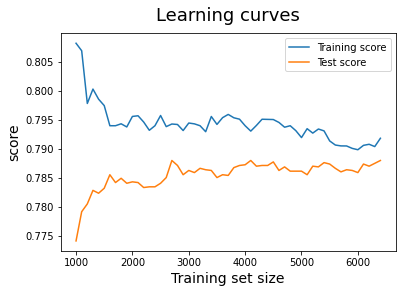

In [564]:
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

The curves start converging approximately well from 3000 onwards. We can therefore use our training set to fit our model and make predictions on the test set.

## SVM

Let us get a quick first estimate by using a non-finetuned SVC

In [391]:
svc = SVC(kernel='rbf', C=0.4)

In [392]:
pipe_ridge = make_pipeline(preproc_baseline, svc)
cross_val_score(pipe_ridge, X, y, cv=5, scoring='f1').mean()

0.4066983149702219

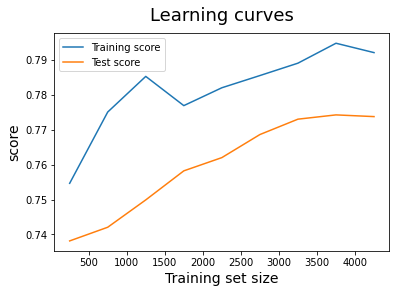

In [394]:
train_sizes = range(250, 4500, 500)

# Get train sizes, train scores, and validation scores using `learning_curve`
train_sizes_svc, train_scores_svc, test_scores_svc = learning_curve(
    estimator=svc, X=X_pre, y=y, train_sizes=train_sizes, cv=3)

# Take the mean of cross-validated train scores and validation scores
train_scores_svc_mean = np.mean(train_scores_svc, axis=1)
test_scores_svc_mean = np.mean(test_scores_svc, axis=1)

plt.plot(train_sizes_svc, train_scores_svc_mean, label = 'Training score')
plt.plot(train_sizes_svc, test_scores_svc_mean, label = 'Test score')
plt.ylabel('score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

Convergence is not optimal as there is not data available. We see that SVC is less sensitive to overfitting initially (which can be seen by the difference between training and test score) due to a strong effect of regularization at small training set sizes.

### Grid search to find optimal parameters

The testing set given in this challenge is unlabelled. Therefore, before performing our gridsearch, a further testing set was defined to yield an unbiased classification table:

In [497]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Let us now find optimal parameters for the regulariation hyperparameter C and gamma, which controls the distance of influence of a single training point. We could also optimize for the kernel using a linear one for example. As this is time-consuming we refrain from also optimizing for different kernels in this notebook.

In [509]:
param_grid = {'svc__C':[0.1,1,10],'svc__gamma':[0.1,0.001]}
search_ridge = GridSearchCV(pipe_ridge, param_grid=param_grid, 
                          cv=3, n_jobs=-1, verbose=2, scoring='f1')

search_ridge.fit(X_train, y_train);
print(search_ridge.best_params_)
search_ridge.best_score_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
{'svc__C': 10, 'svc__gamma': 0.1}


0.5092790166705042

Let us use the best hyperparameters found by our grid search and plot its learning curves to check whether overfitting might be an issue:

In [512]:
svc_opt = SVC(kernel='rbf', C=10, gamma = 0.1,probability=True)

In [535]:
X_pre = pd.DataFrame(preproc_baseline.fit_transform(X))

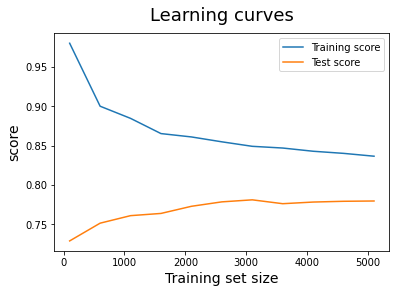

In [537]:
train_sizes = range(100, 5600, 500)

# Get  train sizes, and validation scores using `learning_curve`
train_sizes_svc, train_scores_svc, test_scores_svc = learning_curve(
    estimator=svc_opt, X=X_pre, y=y, train_sizes=train_sizes, cv=3)

# Take the mean of cross-validated train scores and validation scores
train_scores_svc_mean = np.mean(train_scores_svc, axis=1)
test_scores_svc_mean = np.mean(test_scores_svc, axis=1)

plt.plot(train_sizes_svc, train_scores_svc_mean, label = 'Training score')
plt.plot(train_sizes_svc, test_scores_svc_mean, label = 'Test score')
plt.ylabel('score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

Let us have a look at the score of our model (and the f1-score in particular):

In [526]:
y_pred_svc = search_ridge.best_estimator_.predict(X_test)

In [529]:
print(classification_report(y_test,y_pred_svc))

              precision    recall  f1-score   support

           0       0.81      0.91      0.85      1813
           1       0.59      0.39      0.47       636

    accuracy                           0.77      2449
   macro avg       0.70      0.65      0.66      2449
weighted avg       0.75      0.77      0.76      2449



# Generating result files

Due to better convergence when plotting the learning curves and similar scoring,we will use our 'optimal' Logistic Regression model.

In [568]:
pipe_log_opt = make_pipeline(preproc_baseline, LogisticRegression(C = 100))
pipe_log_opt.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6a024c10d0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6a024c1d30>)])),
                ('logisticregression', LogisticRegression(C=100))])

In [572]:
y_pred_log = pipe_log_opt.predict(X_test)

In [573]:
X_test_ids = test_data['INDEX'] # Keep index

Below we compute our predictions:

In [574]:
results = pd.concat([X_test_ids, pd.Series(y_pred_log, name="CLAIM")], axis=1)
results

,INDEX,CLAIM
0,3,0
1,9,0
2,10,0
3,18,0
4,21,0
...,...,...
2136,10279,0
2137,10281,0
2138,10285,0
2139,10294,0


Below we compute the probability for predicting a claim:

In [587]:
pred_proba_df = pipe_log_opt.predict_proba(X_test)
probas = pd.concat([X_test_ids, pd.Series(pred_proba_df[:,1], name="PROB_CLAIM")], axis=1)
probas

,INDEX,PROB_CLAIM
0,3,0.141235
1,9,0.230223
2,10,0.131258
3,18,0.256263
4,21,0.258425
...,...,...
2136,10279,0.304949
2137,10281,0.023017
2138,10285,0.008475
2139,10294,0.316581


Our results will be collected in two csv files:$\newline$

In one file, we assign for each ID in the test set, the probability of the target variable. <br>
In the other file, we have our predictions.

In [369]:
results.to_csv("submission_predictions.csv", header=True, index=False)
probas.to_csv("submission_probas.csv", header=True, index=False)

Clear cache directory at the end

In [ ]:
rmtree(cachedir)